# Upstream Leased Assets Principal Component Analysis (PCA) and Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error)
from sklearn.preprocessing import PowerTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from IPython.display import display

# Import upstream_leased_assets dataframe
upstream_leased_assets=pd.read_csv('upstream_leased_assets.csv')

In [2]:
upstream_leased_assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                1172 non-null   object 
 1   account_id                  1172 non-null   int64  
 2   Year                        1172 non-null   int64  
 3   incorporated_country        1172 non-null   object 
 4   Primary activity            1172 non-null   object 
 5   Primary sector              1172 non-null   object 
 6   Market_Cap_USD              1038 non-null   float64
 7   Third_party_verification    1169 non-null   object 
 8   Revenue_USD                 1044 non-null   float64
 9   ebitda_USD                  1044 non-null   float64
 10  grossProfit_USD             1044 non-null   float64
 11  netIncome_USD               1044 non-null   float64
 12  cashAndCashEquivalents_USD  1044 non-null   float64
 13  shortTermInvestments_USD    1044 

In [3]:
upstream_leased_assets.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,Associated British Foods,1085,2018,United Kingdom,Apparel stores,Discretionary retail,2.051429e+10,Third-party verification or assurance process ...,1.977898e+10,2.363470e+09,...,342900000.0,1.738884e+10,5.582920e+09,381000000.0,9.880600e+08,1.180592e+10,Upstream leased assets,4300.0,2.801746e+06,4072324
1,AstraZeneca,1104,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.441091e+10,Third-party verification or assurance process ...,2.209000e+10,7.165000e+09,...,113000000.0,6.065100e+10,4.660700e+10,922000000.0,1.911300e+10,1.404400e+10,Upstream leased assets,26623.0,7.072529e+05,4072324
2,BT Group,2377,2018,United Kingdom,Telecommunications services,"Media, telecommunications & data center services",2.997109e+10,Third-party verification or assurance process ...,2.975356e+10,9.392920e+09,...,128270000.0,5.878449e+10,4.587240e+10,128270000.0,2.143252e+10,1.291209e+10,Upstream leased assets,56000.0,4.572819e+05,4072324
3,Domino's Pizza Group plc,4835,2018,United Kingdom,Fast food,"Bars, hotels & restaurants",1.451019e+09,No third-party verification or assurance,6.785610e+08,1.296670e+08,...,113157000.0,5.060950e+08,5.029200e+08,63119000.0,2.896870e+08,3.175000e+06,Upstream leased assets,386.0,1.112175e+04,4072324
4,Drax Group,4906,2018,United Kingdom,Non-CCGT generation,Thermal power generation,1.845032e+09,Question not applicable,5.370830e+09,4.086860e+08,...,697357000.0,5.753481e+09,3.504311e+09,3048000.0,7.722870e+08,2.249170e+09,Upstream leased assets,987.0,1.085401e+07,4072324


In [4]:
# Rename features
upstream_leased_assets = upstream_leased_assets.rename(columns={'incorporated_country': 'Countries',
                                          'Primary activity': 'Primary_activity',
                                          'Primary sector': 'Primary_sector'})

# Drop unneeded columns
upstream_leased_assets = upstream_leased_assets.drop(
    ['Third_party_verification', 'Scope_3_emissions_type'], axis=1, errors='ignore')

upstream_leased_assets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                1172 non-null   object 
 1   account_id                  1172 non-null   int64  
 2   Year                        1172 non-null   int64  
 3   Countries                   1172 non-null   object 
 4   Primary_activity            1172 non-null   object 
 5   Primary_sector              1172 non-null   object 
 6   Market_Cap_USD              1038 non-null   float64
 7   Revenue_USD                 1044 non-null   float64
 8   ebitda_USD                  1044 non-null   float64
 9   grossProfit_USD             1044 non-null   float64
 10  netIncome_USD               1044 non-null   float64
 11  cashAndCashEquivalents_USD  1044 non-null   float64
 12  shortTermInvestments_USD    1044 non-null   float64
 13  longTermInvestments_USD     1044 

In [5]:
# Looking at missing data
print(upstream_leased_assets.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                11.4
cashAndCashEquivalents_USD    10.9
totalLiabilities_USD          10.9
totalEquity_USD               10.9
totalDebt_USD                 10.9
Revenue_USD                   10.9
ebitda_USD                    10.9
grossProfit_USD               10.9
netIncome_USD                 10.9
totalInvestments_USD          10.9
shortTermInvestments_USD      10.9
longTermInvestments_USD       10.9
totalAssets_USD               10.9
scope_1_2_emissions_amount     0.3
Scope_3_emissions_amount       0.0
account_name                   0.0
account_id                     0.0
Primary_sector                 0.0
Primary_activity               0.0
Countries                      0.0
Year                           0.0
Year_sq                        0.0
dtype: float64


### Upstream Leased Assets: Principal Component Analysis (PCA) Workflow

- Selects all numeric columns (except categorical fields and target variable) for PCA.
- Applies signed log transformation to mitigate skewness and handle negative values.
- Drops rows with missing data, standardizes features, and fits PCA.
- Appends principal component scores back to the original dataframe for valid rows.
- Plots scree and cumulative explained variance for visual assessment of component importance.
- Prints cumulative variance explained by each principal component.

_Result:_  
`upstream_leased_assets_with_pcs` contains the original data plus principal components for downstream modeling and analysis.

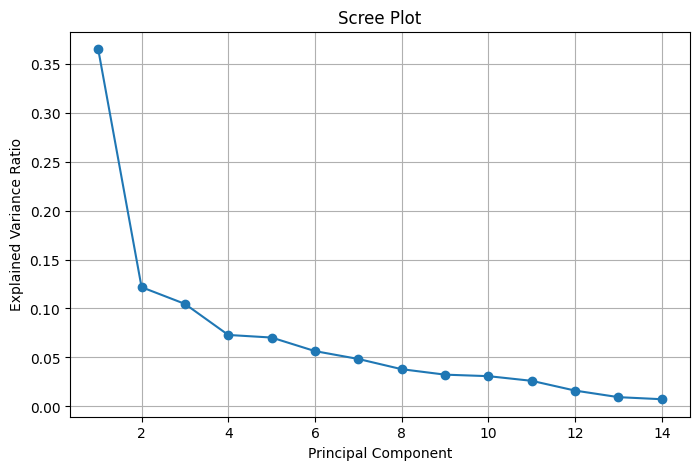

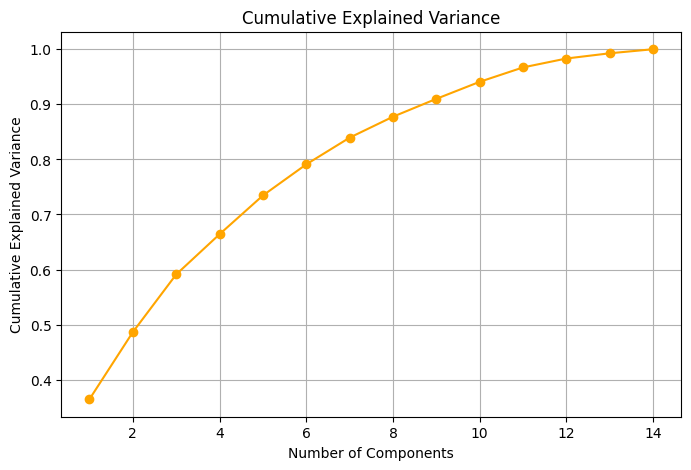

Cumulative variance explained by each additional principal component:
  PC1: 0.3647
  PC2: 0.4865
  PC3: 0.5912
  PC4: 0.6642
  PC5: 0.7345
  PC6: 0.7910
  PC7: 0.8394
  PC8: 0.8775
  PC9: 0.9099
  PC10: 0.9408
  PC11: 0.9670
  PC12: 0.9832
  PC13: 0.9926
  PC14: 1.0000


In [6]:
# --- STEP 1: Select appropriate columns for PCA ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in upstream_leased_assets.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(upstream_leased_assets[col])
    and col != "Scope_3_emissions_amount"
]
X = upstream_leased_assets[numeric_cols].copy()

# --- STEP 2: Apply sign-log transformation ---
def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)

# --- STEP 3: Drop rows with missing values (keep track of indices) ---
X_dropped = X_transformed.dropna()
pca_indices = X_dropped.index

# --- STEP 4: Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

# --- STEP 5: Fit PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- STEP 6: Create a DataFrame for PCs, index matches original ---
num_pcs = X_pca.shape[1]
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
pcs_df = pd.DataFrame(X_pca, columns=pc_columns, index=pca_indices)

# --- STEP 7: Append PCs back to the original DataFrame (only for valid rows) ---
upstream_leased_assets_with_pcs = upstream_leased_assets.copy()
for col in pc_columns:
    upstream_leased_assets_with_pcs[col] = np.nan  # initialize with NaN

upstream_leased_assets_with_pcs.loc[pcs_df.index, pc_columns] = pcs_df

# --- Plots ---
explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_var_ratio) + 1),
    np.cumsum(explained_var_ratio),
    marker='o',
    color='orange'
)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# --- Print cumulative variance explained for each PC ---
cumulative_var = np.cumsum(explained_var_ratio)
print("Cumulative variance explained by each additional principal component:")
for i, var in enumerate(cumulative_var, start=1):
    print(f"  PC{i}: {var:.4f}")

# --- END ---
# upstream_leased_assets_with_pcs now contains the principal components for valid rows.

Nine pc's explains >90% of the variance in the data, while 4 pc's is at the bottom of the "elbow" with much less significant return for each increase in number of pc's.<br>
I'll investigate both 9 pc's and 4 pc's performance on HLM models.

### Upstream Leased Assets: PCA Feature Engineering and Train/Test Split

- Selects numeric columns, applies signed log transformation, and drops missing data.
- Performs PCA (PC9 and PC4) on standardized features; appends principal components to original dataframe.
- Adds signed log-transformed Scope 3 emissions as target.
- Renames columns for consistency if needed.
- **Splits data into train (2018–2022) and test (2023) sets by company and year**.
- Restricts test set to companies present in training for valid modeling.
- Prints train and test set shapes for verification.

_Result:_  
`train_df` and `test_df` now contain all engineered PCA features and are ready for downstream modeling and validation.

In [7]:
# --- Prepare Data ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in upstream_leased_assets.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(upstream_leased_assets[col])
    and col != "Scope_3_emissions_amount"
]
X = upstream_leased_assets[numeric_cols].copy()

def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)
pca_data = X_transformed.dropna().copy()
pca_data["account_id"] = upstream_leased_assets.loc[pca_data.index, "account_id"]
pca_data["Year"] = upstream_leased_assets.loc[pca_data.index, "Year"]

X_pca_input = pca_data.drop(columns=["account_id", "Year"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

# --- PCA for 9 components ---
pca9 = PCA(n_components=9)
pcs9 = pca9.fit_transform(X_scaled)
pcs9_df = pd.DataFrame(pcs9, columns=[f"PC9_{i+1}" for i in range(9)], index=pca_data.index)

# --- PCA for 4 components ---
pca4 = PCA(n_components=4)
pcs4 = pca4.fit_transform(X_scaled)
pcs4_df = pd.DataFrame(pcs4, columns=[f"PC4_{i+1}" for i in range(4)], index=pca_data.index)

# --- Merge all PC features to original DataFrame ---
upstream_leased_assets_pca = upstream_leased_assets.copy()
upstream_leased_assets_pca = upstream_leased_assets_pca.join(pcs9_df)
upstream_leased_assets_pca = upstream_leased_assets_pca.join(pcs4_df)

# --- Add transformed target and optionally other features ---
upstream_leased_assets_pca['slog_Scope_3_emissions_amount'] = sign_log_transform(upstream_leased_assets_pca['Scope_3_emissions_amount'])

# Optional: Rename columns for consistency
upstream_leased_assets_pca = upstream_leased_assets_pca.rename(columns={'incorporated_country': 'Countries',
                                                         'Primary activity': 'Primary_activity',
                                                         'Primary sector': 'Primary_sector'})

# Now upstream_leased_assets_pca contains all PC9 and PC4 features for downstream HLM modeling

# --- Split train/test by company and year ---
train_df = upstream_leased_assets_pca[upstream_leased_assets_pca['Year'].between(2018, 2022)].copy()
test_df  = upstream_leased_assets_pca[upstream_leased_assets_pca['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (917, 36)
Test shape: (208, 36)


In [8]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 0 to 916
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   917 non-null    object 
 1   account_id                     917 non-null    int64  
 2   Year                           917 non-null    int64  
 3   Countries                      917 non-null    object 
 4   Primary_activity               917 non-null    object 
 5   Primary_sector                 917 non-null    object 
 6   Market_Cap_USD                 805 non-null    float64
 7   Revenue_USD                    817 non-null    float64
 8   ebitda_USD                     817 non-null    float64
 9   grossProfit_USD                817 non-null    float64
 10  netIncome_USD                  817 non-null    float64
 11  cashAndCashEquivalents_USD     817 non-null    float64
 12  shortTermInvestments_USD       817 non-null    float64


### Upstream Leased Assets: PC9 HLM Model with Train/Test Splits

- Performs PCA on log-transformed numeric features, extracting both PC9 and PC4 features.
- Appends principal components to the original dataframe and adds signed log-transformed Scope 3 emissions as the target.
- Splits the data into train (2018–2022) and test (2023) sets, restricting test set to companies present in training.
- Drops missing values on required columns and ensures categorical levels in test are present in train.
- Fits a hierarchical linear mixed-effects model using PC9 features plus categorical fixed effects, grouped by company.
- Evaluates and visualizes test set predictions, calculates R², RMSE, MAE, RMSLE, and other metrics.
- Returns a metrics dictionary for summary table comparison.

_Result:_  
`train_df_PC9` and `test_df_PC9` are ready for HLM modeling, with full metrics and visualizations for model performance.

/Users/amberjensen/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


                                                                      Mixed Linear Model Regression Results
Model:                                              MixedLM                                   Dependent Variable:                                   slog_Scope_3_emissions_amount
No. Observations:                                   803                                       Method:                                               ML                           
No. Groups:                                         248                                       Scale:                                                3.0560                       
Min. group size:                                    1                                         Log-Likelihood:                                       -1587.9848                   
Max. group size:                                    5                                         Converged:                                            Yes                          
Me

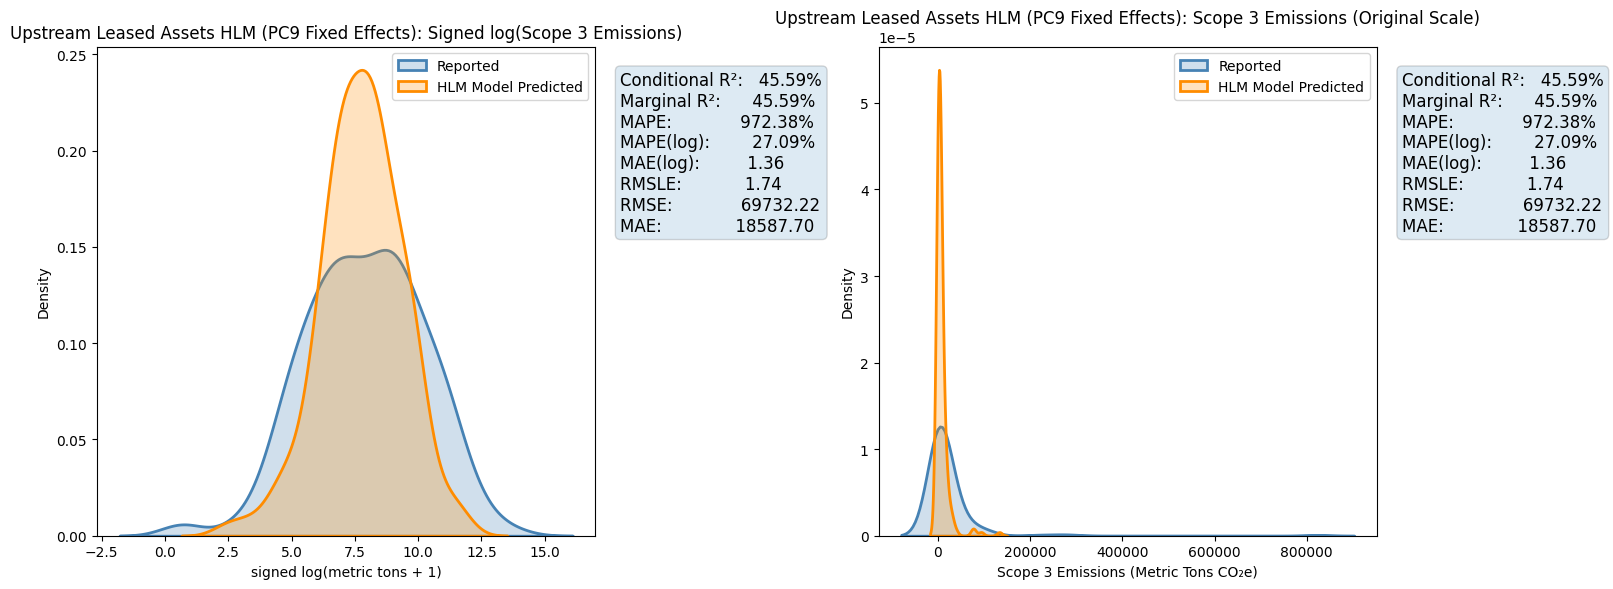

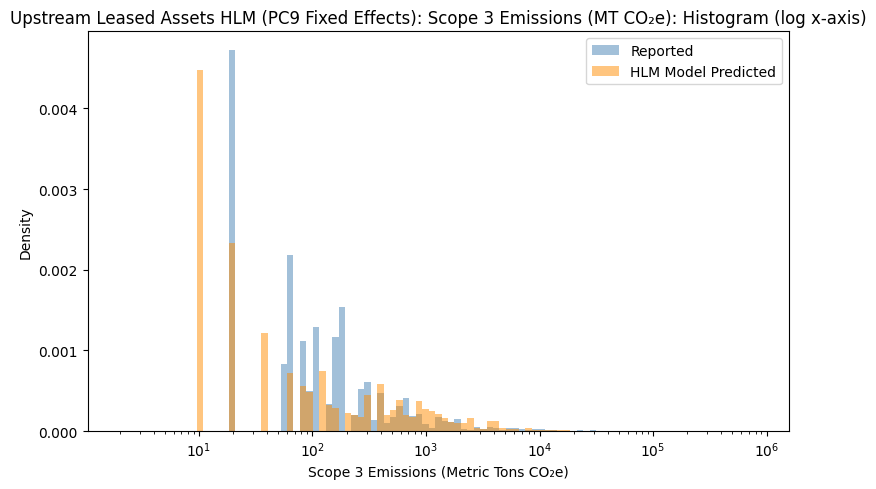

In [9]:
# --- Prepare Data ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in upstream_leased_assets.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(upstream_leased_assets[col])
    and col != "Scope_3_emissions_amount"
]
X = upstream_leased_assets[numeric_cols].copy()

def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)
pca_data = X_transformed.dropna().copy()
pca_data["account_id"] = upstream_leased_assets.loc[pca_data.index, "account_id"]
pca_data["Year"] = upstream_leased_assets.loc[pca_data.index, "Year"]

X_pca_input = pca_data.drop(columns=["account_id", "Year"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

# --- PCA for 9 components ---
pca9 = PCA(n_components=9)
pcs9 = pca9.fit_transform(X_scaled)
pcs9_df = pd.DataFrame(pcs9, columns=[f"PC9_{i+1}" for i in range(9)], index=pca_data.index)

# --- PCA for 4 components (to preserve PC4 features in downstream modeling) ---
pca4 = PCA(n_components=4)
pcs4 = pca4.fit_transform(X_scaled)
pcs4_df = pd.DataFrame(pcs4, columns=[f"PC4_{i+1}" for i in range(4)], index=pca_data.index)

# --- Merge all PC features to original DataFrame ---
upstream_leased_assets_pca = upstream_leased_assets.copy()
upstream_leased_assets_pca = upstream_leased_assets_pca.join(pcs9_df)
upstream_leased_assets_pca = upstream_leased_assets_pca.join(pcs4_df)

# --- Add transformed target and optionally other features ---
upstream_leased_assets_pca['slog_Scope_3_emissions_amount'] = sign_log_transform(upstream_leased_assets_pca['Scope_3_emissions_amount'])

# Optional: Rename columns for consistency
upstream_leased_assets_pca = upstream_leased_assets_pca.rename(columns={'incorporated_country': 'Countries',
                                                         'Primary activity': 'Primary_activity',
                                                         'Primary sector': 'Primary_sector'})

# --- 1. Split for HLM model using ONLY rows used in PCA (pca_data.index) ---
valid_idx = pca_data.index
upstream_leased_assets_pca_valid = upstream_leased_assets_pca.loc[valid_idx].copy()

# Define train/test splits based on years and shared accounts
train_df = upstream_leased_assets_pca_valid[upstream_leased_assets_pca_valid['Year'].between(2018, 2022)].copy()
test_df = upstream_leased_assets_pca_valid[upstream_leased_assets_pca_valid['Year'] == 2023].copy()
valid_accounts = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_accounts)].copy()

# --- 2. Filter for required columns only ---
feature_cols_PC9 = [f'PC9_{i}' for i in range(1, 10)]  # includes PC9_1 to PC9_9
target_col_PC9 = 'slog_Scope_3_emissions_amount'
cat_cols_PC9 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC9 = feature_cols_PC9 + [target_col_PC9] + cat_cols_PC9
train_df_PC9 = train_df.dropna(subset=all_model_vars_PC9).copy()
test_df_PC9 = test_df.dropna(subset=all_model_vars_PC9).copy()

# --- 3. Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC9[cat_col].unique())
    n_before = len(test_df_PC9)
    test_df_PC9 = test_df_PC9[test_df_PC9[cat_col].isin(train_cats)]
    n_after = len(test_df_PC9)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC9.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- 4. Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_PC9) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC9} ~ {fixed_effects}'

    # --- 5. Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC9, groups=train_df_PC9['account_id'])
        mdf_PC9 = md.fit(reml=False)
    print(mdf_PC9.summary())

    # --- 6. CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_PC9.fittedvalues)
    var_resid = mdf_PC9.scale
    var_random = mdf_PC9.cov_re.iloc[0, 0] if mdf_PC9.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- 7. Predict on test set ---
    test_df_PC9['predicted_log'] = mdf_PC9.predict(test_df_PC9)
    test_df_PC9['predicted'] = np.sign(test_df_PC9['predicted_log']) * (np.expm1(np.abs(test_df_PC9['predicted_log'])))

    # --- 8. Metrics ---
    y_true_log = test_df_PC9[target_col_PC9]
    y_pred_log = test_df_PC9['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC9['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nUpstream Leased Assets HLM with PC9 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- 9. Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC9.params,
        'pvalue': mdf_PC9.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- 10. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Upstream Leased Assets HLM (PC9 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Upstream Leased Assets HLM (PC9 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Upstream Leased Assets HLM (PC9 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 11. RETURN METRICS FOR SUMMARY TABLE ---
    PC9_model_metrics = {
        "Model": "HLM PC9",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC9),
        "# Obs (test)": len(test_df_PC9),
        "# Obs (train/test)": f"{len(train_df_PC9)}/{len(test_df_PC9)}"
    }

The warning indicates that the model likely has some instability in parameter estimation, especially for the fixed effects. The results for affected coefficients should be interpreted with caution.

### Upstream Leased Assets: PC4 HLM Model Using Pre-Split Train/Test Data

- Uses pre-split `train_df` and `test_df` dataframes containing engineered features and targets.
- Filters to rows with complete data for PC4 features, target, and required categorical columns.
- Drops near-constant and perfectly collinear PC4 features from predictors for modeling stability.
- Ensures all categorical levels in test are present in train to avoid model errors.
- Fits a hierarchical linear mixed-effects model (HLM) with PC4 features, country, activity, and year as fixed effects, grouped by company.
- Evaluates and visualizes model predictions, calculates R², RMSE, MAE, RMSLE, and other metrics on the test set.
- Returns a metrics dictionary for summary table comparison.

_Result:_  
`train_df_pc4` and `test_df_pc4` provide a clean workflow for HLM modeling and reproducible test set evaluation.


No PC4 columns dropped for being constant or collinear.
Converged: True
                                               Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    slog_Scope_3_emissions_amount
No. Observations:                    803                        Method:                                ML                           
No. Groups:                          248                        Scale:                                 1.1325                       
Min. group size:                     1                          Log-Likelihood:                        -1366.3916                   
Max. group size:                     5                          Converged:                             Yes                          
Mean group size:                     3.2                                                                                            
--------------------------------------------

/Users/amberjensen/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


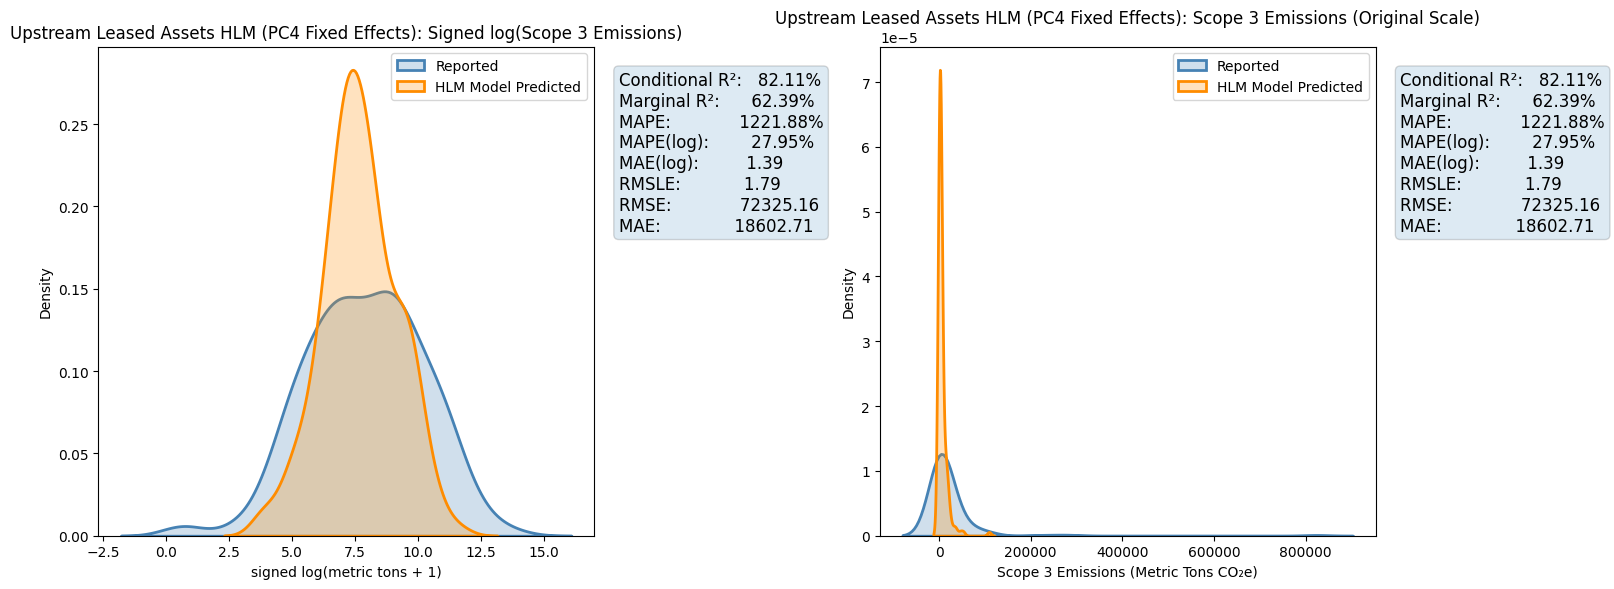

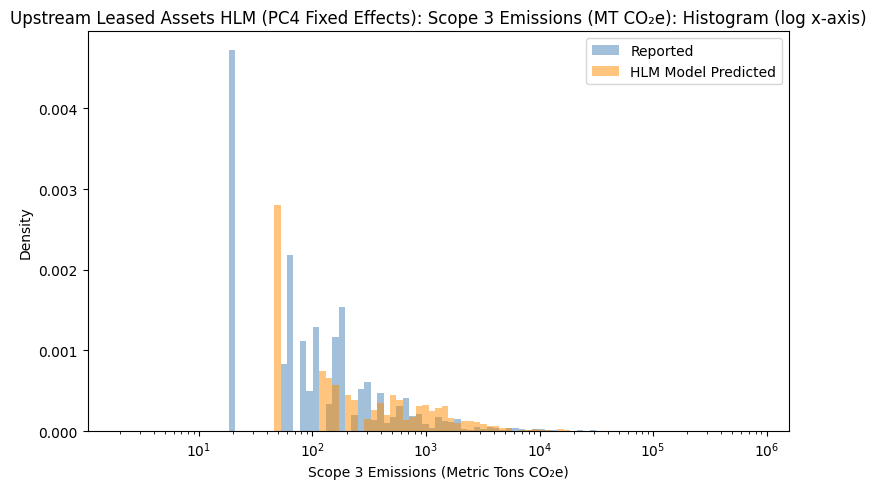

In [10]:
# --- Use already split train_df and test_df ---

feature_cols_pc4 = [f'PC4_{i}' for i in range(1, 5)]
target_col_pc4 = 'slog_Scope_3_emissions_amount'
cat_cols_pc4 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_pc4 = feature_cols_pc4 + [target_col_pc4] + cat_cols_pc4
train_df_pc4 = train_df.dropna(subset=all_model_vars_pc4).copy()
test_df_pc4 = test_df.dropna(subset=all_model_vars_pc4).copy()

# --- PATCH: Drop constant and perfectly collinear columns, with reporting ---
dropped_columns_report = []

# 1. Drop near-constant columns
const_cols = [col for col in feature_cols_pc4 if train_df_pc4[col].std() < 1e-8]
if const_cols:
    for col in const_cols:
        dropped_columns_report.append((col, "near-constant (std < 1e-8)"))
    print("Dropping near-constant columns from PC4 predictors:", const_cols)
    feature_cols_pc4 = [col for col in feature_cols_pc4 if col not in const_cols]

# 2. Drop perfectly collinear columns
corr_matrix = train_df_pc4[feature_cols_pc4].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
dupe_cols = [column for column in upper.columns if any(upper[column] == 1.0)]
if dupe_cols:
    for col in dupe_cols:
        dropped_columns_report.append((col, "perfectly collinear (correlation = 1.0)"))
    print("Dropping collinear columns from PC4 predictors:", dupe_cols)
    feature_cols_pc4 = [col for col in feature_cols_pc4 if col not in dupe_cols]

# Print detailed drop report
if dropped_columns_report:
    print("\nDropped the following columns from PC4 predictors before fitting:")
    for col, reason in dropped_columns_report:
        print(f"  - {col}: {reason}")
else:
    print("\nNo PC4 columns dropped for being constant or collinear.")

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_pc4[cat_col].unique())
    n_before = len(test_df_pc4)
    test_df_pc4 = test_df_pc4[test_df_pc4[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_pc4) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_pc4} ~ {fixed_effects}'

    # --- Fit the mixed-effects model with robust optimizer ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            mdf_pc4 = smf.mixedlm(formula, data=train_df_pc4, groups=train_df_pc4['account_id']).fit(
                reml=False, method='nm', maxiter=1500, full_output=True
            )
        except Exception as e:
            print("Model did not converge with Nelder-Mead. Trying Powell optimizer...")
            mdf_pc4 = smf.mixedlm(formula, data=train_df_pc4, groups=train_df_pc4['account_id']).fit(
                reml=False, method='powell', maxiter=1500, full_output=True
            )
    print("Converged:", mdf_pc4.converged)
    print(mdf_pc4.summary())

    # --- CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_pc4.fittedvalues)
    var_resid = mdf_pc4.scale
    var_random = mdf_pc4.cov_re.iloc[0, 0] if mdf_pc4.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_pc4['predicted_log'] = mdf_pc4.predict(test_df_pc4)
    test_df_pc4['predicted'] = np.sign(test_df_pc4['predicted_log']) * (np.expm1(np.abs(test_df_pc4['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_pc4[target_col_pc4]
    y_pred_log = test_df_pc4['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nUpstream Leased Assets HLM with PC4 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4.params,
        'pvalue': mdf_pc4.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Upstream Leased Assets HLM (PC4 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Upstream Leased Assets HLM (PC4 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Upstream Leased Assets HLM (PC4 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    pc4_model_metrics = {
        "Model": "HLM PC4",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4),
        "# Obs (test)": len(test_df_pc4),
        "# Obs (train/test)": f"{len(train_df_pc4)}/{len(test_df_pc4)}"
    }

In [11]:
print(train_df_pc4['Countries'].value_counts())
print(train_df_pc4['Primary_activity'].value_counts())

Countries
Japan             214
USA               187
United Kingdom     66
France             44
Canada             39
Spain              31
Germany            29
South Korea        29
Italy              21
Australia          21
South Africa       20
Netherlands        17
China              15
Switzerland        13
Brazil             12
Ireland            11
Sweden              9
Norway              8
Portugal            4
New Zealand         4
Thailand            3
Finland             2
India               2
Chile               1
Luxembourg          1
Name: count, dtype: int64
Primary_activity
Insurance                       48
Telecommunications services     43
Pharmaceuticals                 39
Electronic components           39
Other base chemicals            30
                                ..
Pulp & paper mills               1
Grain & corn milling             1
Other containers & packaging     1
Wind generation                  1
Engineering services             1
Name: count,

## Patch for Extreme Coefficients and Sparse Data in HLM (PC4)

This workflow patch merges rare categories in `Countries` and `Primary_activity` (those with fewer than 5 training samples) into an "Other" group, both in train and test sets, before fitting a hierarchical linear mixed-effects model.

**Key Steps:**
- Count samples per category for `Countries` and `Primary_activity`.
- Replace sparse categories (<5 samples) with "Other" in both train and test dataframes.
- Improves model reliability by preventing extreme/NaN coefficients and instability associated with sparse categories.
- All subsequent modeling, evaluation, and visualization steps remain unchanged.

**Benefits:**
- More robust inference and coefficient estimates.
- Reduced risk of model warnings and unreliable statistics.
- Retains all data for rare categories, improving generalizability.

**Usage:**  
Add the patch before model fitting in your workflow and proceed as normal.


No PC4 columns dropped for being constant or collinear.
Converged: True
                                        Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                803                   Method:                           ML                           
No. Groups:                      248                   Scale:                            0.6994                       
Min. group size:                 1                     Log-Likelihood:                   -1328.7848                   
Max. group size:                 5                     Converged:                        Yes                          
Mean group size:                 3.2                                                                                  
----------------------------------------------------------------------------------------------------------------------
                

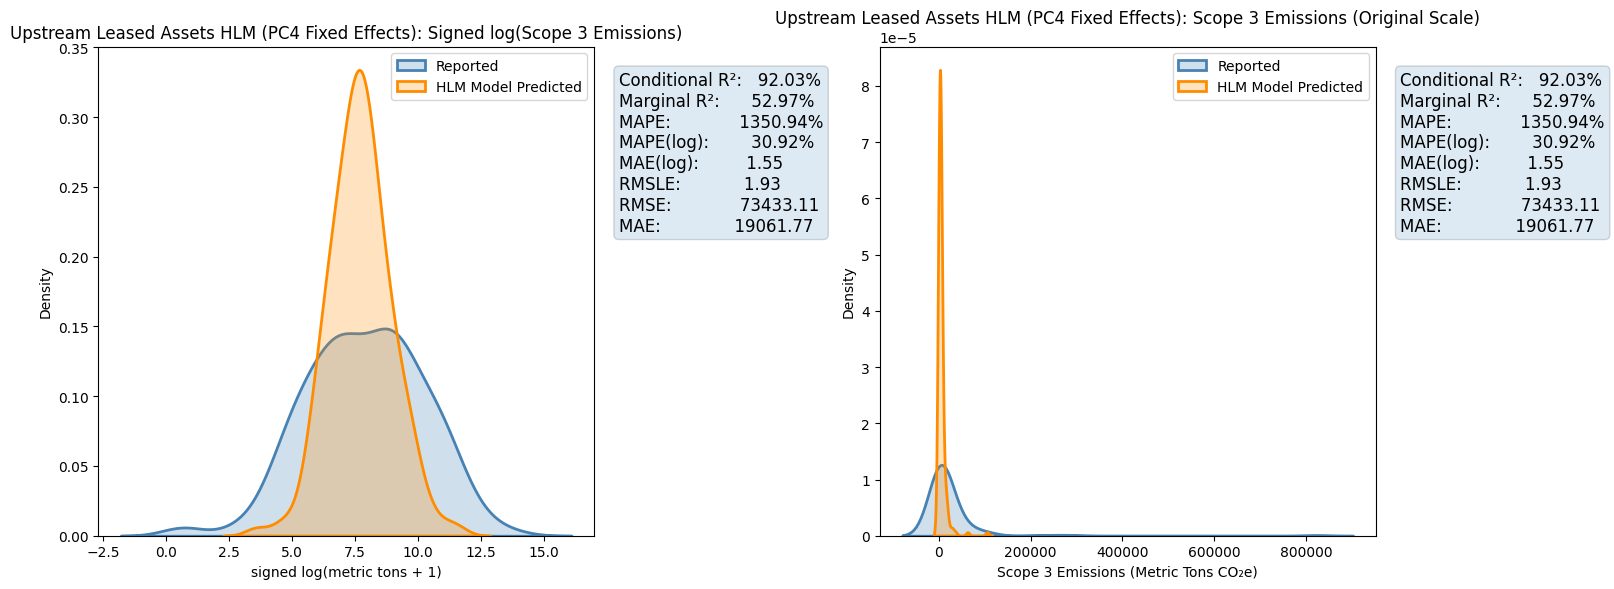

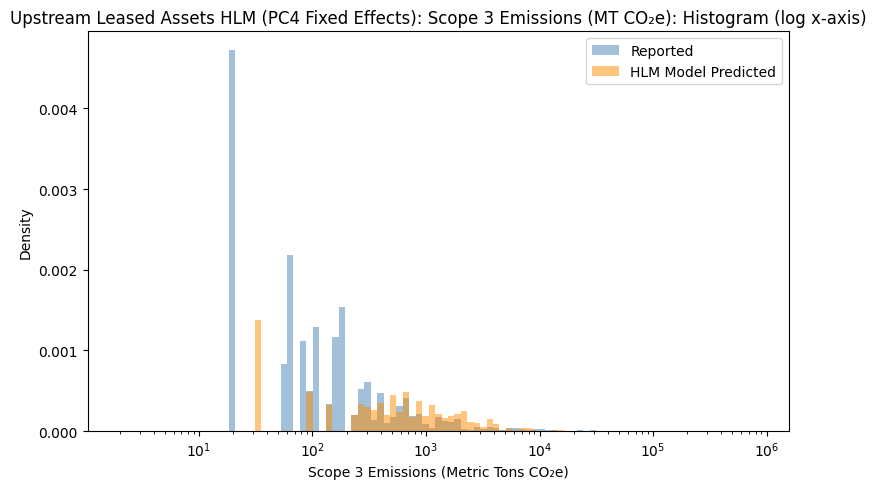

In [12]:
# --- Merge rare Countries and Primary_activity into "Other" for model stability ---

min_count = 5

# Merge rare countries
country_counts = train_df_pc4['Countries'].value_counts()
rare_countries = country_counts[country_counts < min_count].index
train_df_pc4['Countries'] = train_df_pc4['Countries'].replace(rare_countries, 'Other')
test_df_pc4['Countries'] = test_df_pc4['Countries'].replace(rare_countries, 'Other')

# Merge rare primary activities
activity_counts = train_df_pc4['Primary_activity'].value_counts()
rare_activities = activity_counts[activity_counts < min_count].index
train_df_pc4['Primary_activity'] = train_df_pc4['Primary_activity'].replace(rare_activities, 'Other')
test_df_pc4['Primary_activity'] = test_df_pc4['Primary_activity'].replace(rare_activities, 'Other')

# --- Continue with modeling as before ---

feature_cols_pc4 = [f'PC4_{i}' for i in range(1, 5)]
target_col_pc4 = 'slog_Scope_3_emissions_amount'
cat_cols_pc4 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_pc4 = feature_cols_pc4 + [target_col_pc4] + cat_cols_pc4
train_df_pc4 = train_df_pc4.dropna(subset=all_model_vars_pc4).copy()
test_df_pc4 = test_df_pc4.dropna(subset=all_model_vars_pc4).copy()

# --- PATCH: Drop constant and perfectly collinear columns, with reporting ---
dropped_columns_report = []

# 1. Drop near-constant columns
const_cols = [col for col in feature_cols_pc4 if train_df_pc4[col].std() < 1e-8]
if const_cols:
    for col in const_cols:
        dropped_columns_report.append((col, "near-constant (std < 1e-8)"))
    print("Dropping near-constant columns from PC4 predictors:", const_cols)
    feature_cols_pc4 = [col for col in feature_cols_pc4 if col not in const_cols]

# 2. Drop perfectly collinear columns
corr_matrix = train_df_pc4[feature_cols_pc4].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
dupe_cols = [column for column in upper.columns if any(upper[column] == 1.0)]
if dupe_cols:
    for col in dupe_cols:
        dropped_columns_report.append((col, "perfectly collinear (correlation = 1.0)"))
    print("Dropping collinear columns from PC4 predictors:", dupe_cols)
    feature_cols_pc4 = [col for col in feature_cols_pc4 if col not in dupe_cols]

# Print detailed drop report
if dropped_columns_report:
    print("\nDropped the following columns from PC4 predictors before fitting:")
    for col, reason in dropped_columns_report:
        print(f"  - {col}: {reason}")
else:
    print("\nNo PC4 columns dropped for being constant or collinear.")

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_pc4[cat_col].unique())
    n_before = len(test_df_pc4)
    test_df_pc4 = test_df_pc4[test_df_pc4[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_pc4) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_pc4} ~ {fixed_effects}'

    # --- Fit the mixed-effects model with robust optimizer ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            mdf_pc4 = smf.mixedlm(formula, data=train_df_pc4, groups=train_df_pc4['account_id']).fit(
                reml=False, method='nm', maxiter=1500, full_output=True
            )
        except Exception as e:
            print("Model did not converge with Nelder-Mead. Trying Powell optimizer...")
            mdf_pc4 = smf.mixedlm(formula, data=train_df_pc4, groups=train_df_pc4['account_id']).fit(
                reml=False, method='powell', maxiter=1500, full_output=True
            )
    print("Converged:", mdf_pc4.converged)
    print(mdf_pc4.summary())

    # --- CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_pc4.fittedvalues)
    var_resid = mdf_pc4.scale
    var_random = mdf_pc4.cov_re.iloc[0, 0] if mdf_pc4.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_pc4['predicted_log'] = mdf_pc4.predict(test_df_pc4)
    test_df_pc4['predicted'] = np.sign(test_df_pc4['predicted_log']) * (np.expm1(np.abs(test_df_pc4['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_pc4[target_col_pc4]
    y_pred_log = test_df_pc4['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nUpstream Leased Assets HLM with PC4 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4.params,
        'pvalue': mdf_pc4.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Upstream Leased Assets HLM (PC4 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Upstream Leased Assets HLM (PC4 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Upstream Leased Assets HLM (PC4 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    pc4_model_metrics = {
        "Model": "HLM PC4",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4),
        "# Obs (test)": len(test_df_pc4),
        "# Obs (train/test)": f"{len(train_df_pc4)}/{len(test_df_pc4)}"
    }

Now I'll look into hierarchical clustering to determine if that may add value to increasing prediction accuracy.

## Brief: Appending Hierarchical Cluster Feature to Train/Test Sets

- PC4 features from upstream_leased_assets_pca were used for hierarchical clustering.
- Optimal cluster count selected via silhouette score.
- Cluster labels assigned to valid rows in upstream_leased_assets_pca as the new 'Cluster' feature.
- The 'Cluster' feature is appended to pre-existing `train_df` and `test_df` using their original indices.
- Enables downstream modeling or analysis using cluster membership as an additional categorical feature.

**Usage:**  
After clustering, simply append the 'Cluster' column from `upstream_leased_assets_pca_clusters` to your `train_df` and `test_df` for enhanced segmentation and analysis.

Optimal number of clusters (highest silhouette score): 2


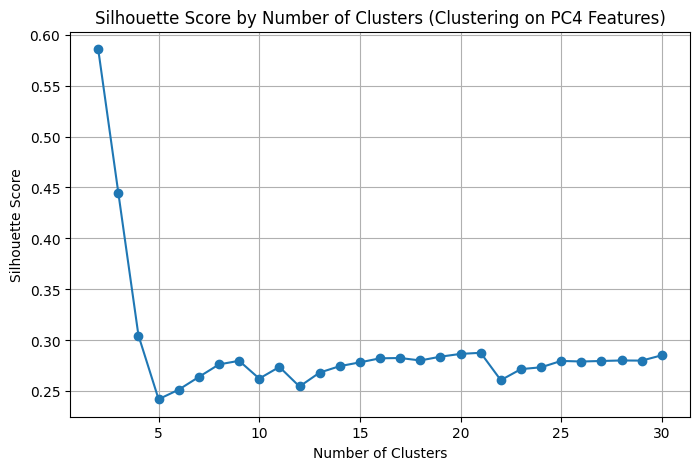

Number of observations in each cluster:
2    995
1     32
Name: count, dtype: int64


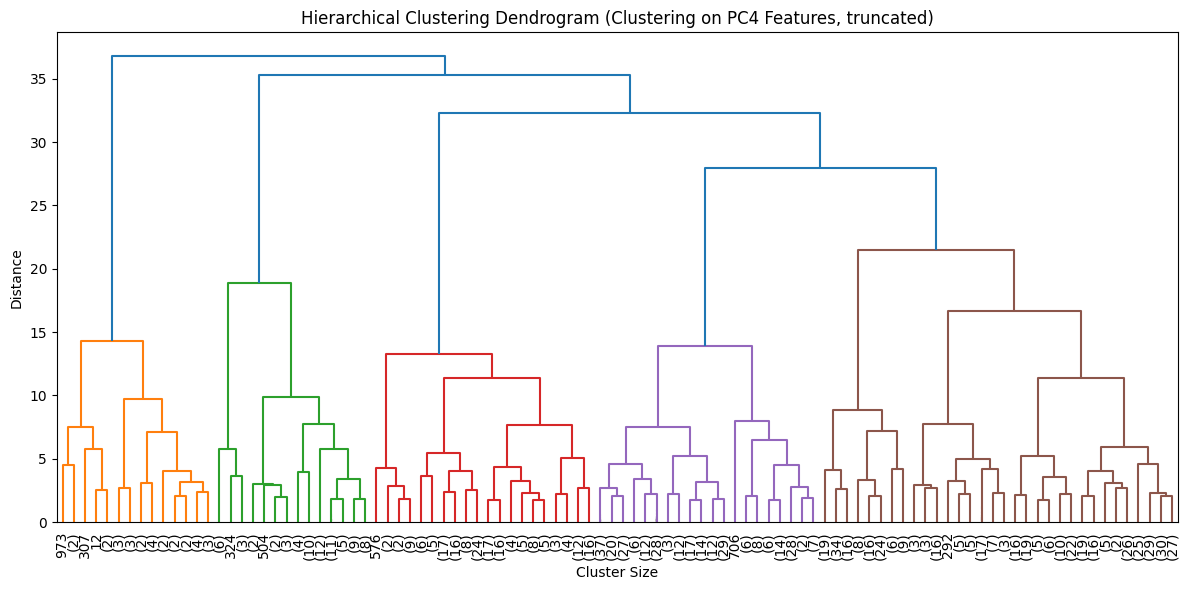

In [14]:
# --- STEP 1: Select PC4 PCA components for clustering ---
pc4_cols = [f'PC4_{i}' for i in range(1, 5)]
X_pc4 = upstream_leased_assets_pca[pc4_cols].dropna()
clust_indices = X_pc4.index

# --- STEP 2: Standardize the PC4 data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pc4)

# --- STEP 3: Hierarchical clustering (Ward linkage) ---
Z = linkage(X_scaled, method='ward')

# --- STEP 4: Find optimal number of clusters using silhouette score ---
range_n_clusters = range(2, 31)  # 2 to 30 clusters
sil_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"Optimal number of clusters (highest silhouette score): {optimal_n_clusters}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (Clustering on PC4 Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# --- STEP 5: Assign optimal cluster labels ---
labels_optimal = fcluster(Z, optimal_n_clusters, criterion='maxclust')

# --- STEP 6: Append cluster labels back to original DataFrame (only for valid rows) ---
upstream_leased_assets_pca_clusters = upstream_leased_assets_pca.copy()
upstream_leased_assets_pca_clusters['Cluster'] = np.nan  # initialize with NaN
upstream_leased_assets_pca_clusters.loc[clust_indices, 'Cluster'] = labels_optimal

# --- Print cluster counts ---
print("Number of observations in each cluster:")
print(pd.Series(labels_optimal).value_counts())

# --- Optionally plot dendrogram (subset for readability) ---
plt.figure(figsize=(12, 6))
sample_size = min(100, len(X_scaled))  # Plot up to 100 samples for clarity
dendrogram(Z, truncate_mode='lastp', p=sample_size, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Clustering on PC4 Features, truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# --- STEP 7: Append Cluster feature to train_df and test_df ---

# Ensure cluster assignment is integer and matches index
cluster_map = upstream_leased_assets_pca_clusters['Cluster']

# Add cluster labels to train and test
train_df['Cluster'] = cluster_map.loc[train_df.index].astype(pd.Int64Dtype())
test_df['Cluster']  = cluster_map.loc[test_df.index].astype(pd.Int64Dtype())

In [15]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 803 entries, 0 to 916
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   803 non-null    object 
 1   account_id                     803 non-null    int64  
 2   Year                           803 non-null    int64  
 3   Countries                      803 non-null    object 
 4   Primary_activity               803 non-null    object 
 5   Primary_sector                 803 non-null    object 
 6   Market_Cap_USD                 803 non-null    float64
 7   Revenue_USD                    803 non-null    float64
 8   ebitda_USD                     803 non-null    float64
 9   grossProfit_USD                803 non-null    float64
 10  netIncome_USD                  803 non-null    float64
 11  cashAndCashEquivalents_USD     803 non-null    float64
 12  shortTermInvestments_USD       803 non-null    float64


## PC4 + Cluster HLM with Train/Test

- Uses train_df and test_df with appended 'Cluster' (from hierarchical clustering on PC4).
- Fits HLM using PC4 features, Cluster, Countries, Primary_activity, Year.
- Cleans predictors and categories for reliability.
- Evaluates model on test set.

**Purpose:**  
Adds cluster segmentation to HLM for improved analysis.


REPORT: DID NOT drop any PC4/Cluster columns for being constant or collinear.
Removing 2 levels in 'Countries' with only one sample from training data.
Removing 6 levels in 'Primary_activity' with only one sample from training data.
INFO: Training categorical 'Countries' has 23 levels after drop.
INFO: Training categorical 'Primary_activity' has 76 levels after drop.
INFO: Training categorical 'Cluster' has 2 levels after drop.
Model did not converge with Nelder-Mead. Trying Powell optimizer...
Converged: True
                                          Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                slog_Scope_3_emissions_amount
No. Observations:                 803                    Method:                            ML                           
No. Groups:                       248                    Scale:                             0.7549                       
Min. group size:                  1  

/Users/amberjensen/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


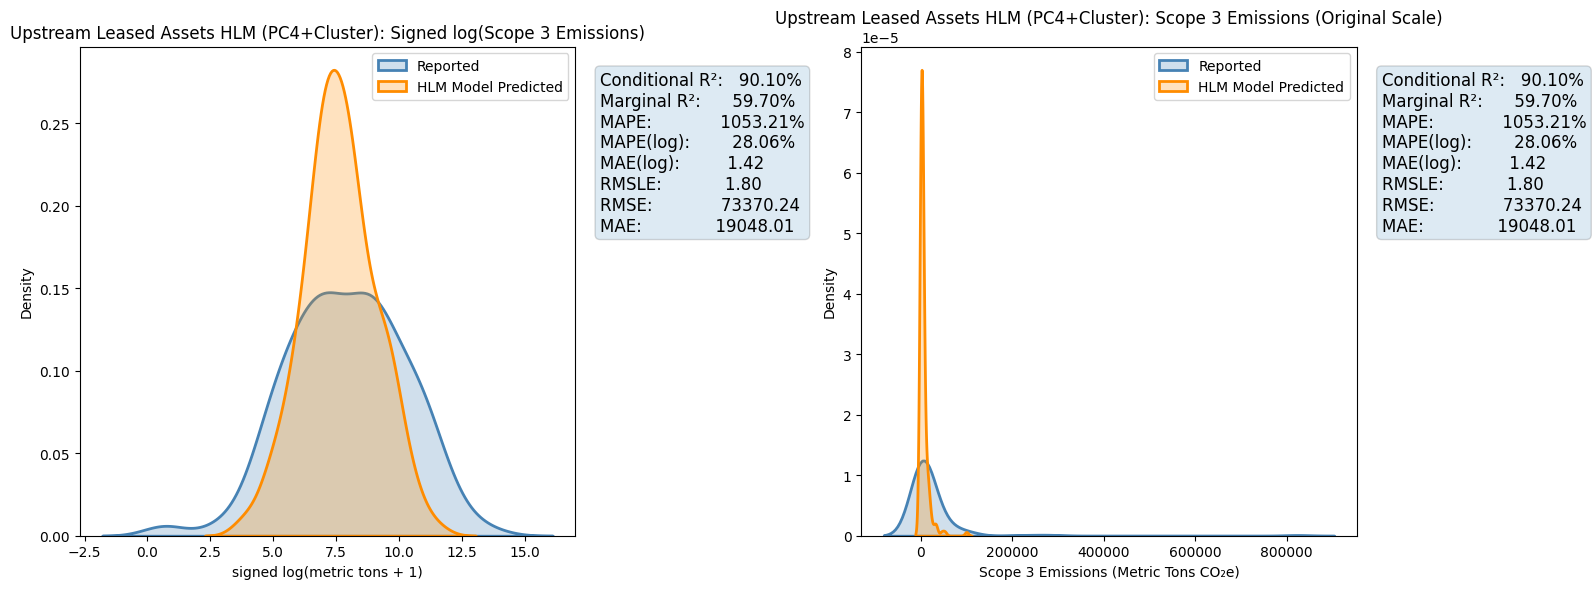

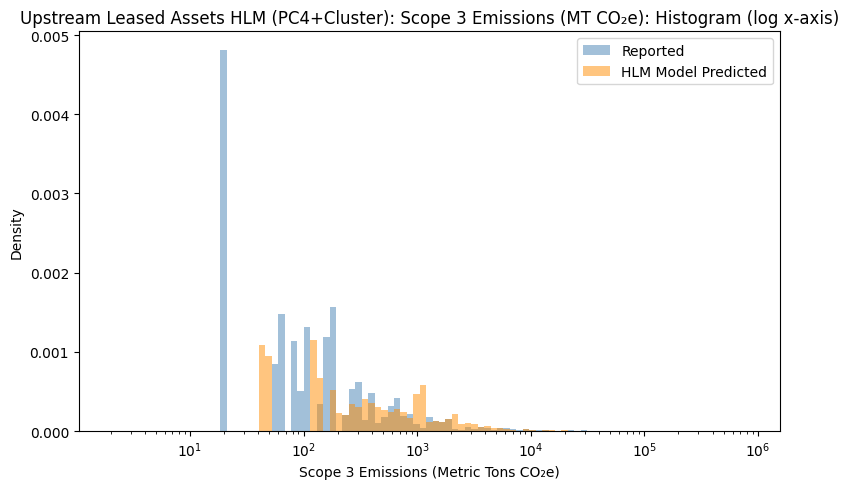

In [16]:
# --- PC4 + Cluster HLM using pre-split train_df and test_df ---

feature_cols_pc4_cluster = [f'PC4_{i}' for i in range(1, 5)] + ['Cluster']
target_col = 'slog_Scope_3_emissions_amount'
cat_cols = ['Countries', 'Year', 'account_id', 'Primary_activity']
all_model_vars = feature_cols_pc4_cluster + [target_col] + cat_cols

# --- Ensure Cluster feature exists and is integer ---
if 'Cluster' not in train_df.columns and 'cluster' in train_df.columns:
    train_df['Cluster'] = train_df['cluster']
if 'Cluster' not in test_df.columns and 'cluster' in test_df.columns:
    test_df['Cluster'] = test_df['cluster']
train_df['Cluster'] = train_df['Cluster'].astype(pd.Int64Dtype())
test_df['Cluster']  = test_df['Cluster'].astype(pd.Int64Dtype())

# --- Drop any remaining missing values ---
train_df_pc4c = train_df.dropna(subset=all_model_vars).copy()
test_df_pc4c  = test_df.dropna(subset=all_model_vars).copy()

# --- Drop constant and perfectly collinear columns, with reporting ---
dropped_columns_report = []
for col in feature_cols_pc4_cluster:
    if train_df_pc4c[col].std() < 1e-8:
        dropped_columns_report.append((col, "near-constant (std < 1e-8)"))
feature_cols_pc4_cluster = [col for col in feature_cols_pc4_cluster if col not in [c for c, _ in dropped_columns_report]]

if feature_cols_pc4_cluster:
    corr_matrix = train_df_pc4c[feature_cols_pc4_cluster].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    dupe_cols = [column for column in upper.columns if any(upper[column] == 1.0)]
    for col in dupe_cols:
        dropped_columns_report.append((col, "perfectly collinear (correlation = 1.0)"))
    feature_cols_pc4_cluster = [col for col in feature_cols_pc4_cluster if col not in dupe_cols]

if dropped_columns_report:
    print("\nREPORT: Dropped the following columns from predictors before fitting:")
    for col, reason in dropped_columns_report:
        print(f"  - {col}: {reason}")
else:
    print("\nREPORT: DID NOT drop any PC4/Cluster columns for being constant or collinear.")

# --- Remove categorical levels with only one sample in training ---
for cat in ['Countries', 'Primary_activity', 'Cluster']:
    vc = train_df_pc4c[cat].value_counts()
    single_sample_levels = vc[vc == 1].index
    if len(single_sample_levels) > 0:
        print(f"Removing {len(single_sample_levels)} levels in '{cat}' with only one sample from training data.")
        train_df_pc4c = train_df_pc4c[~train_df_pc4c[cat].isin(single_sample_levels)]

# Print final info
for cat in ['Countries', 'Primary_activity', 'Cluster']:
    n_levels = train_df_pc4c[cat].nunique()
    print(f"INFO: Training categorical '{cat}' has {n_levels} levels after drop.")

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity', 'Cluster']:
    train_cats = set(train_df_pc4c[cat_col].unique())
    n_before = len(test_df_pc4c)
    test_df_pc4c = test_df_pc4c[test_df_pc4c[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4c)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4c.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    fixed_effects = (
        ' + '.join([f'C({col})' if col == 'Cluster' else col for col in feature_cols_pc4_cluster]) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col} ~ {fixed_effects}'
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            md = smf.mixedlm(formula, data=train_df_pc4c, groups=train_df_pc4c['account_id'])
            mdf_pc4c = md.fit(reml=False, method='nm', maxiter=1500, full_output=True)
        except Exception as e:
            print("Model did not converge with Nelder-Mead. Trying Powell optimizer...")
            try:
                mdf_pc4c = md.fit(reml=False, method='powell', maxiter=1500, full_output=True)
            except Exception as err2:
                print("Model did not converge with Powell either. Singular matrix likely due to categorical or design matrix structure.")
                from patsy import dmatrix
                X_fe = dmatrix(formula.split("~")[1], train_df_pc4c, return_type='dataframe')
                rank = np.linalg.matrix_rank(X_fe.values)
                print(f"DEBUG: Fixed effects design matrix shape: {X_fe.shape}, rank: {rank}")
                print(f"DEBUG: Number of predictors: {X_fe.shape[1]}")
                print("DEBUG: If rank < number of predictors, you have linear dependencies.")
                raise err2
    print("Converged:", mdf_pc4c.converged)
    print(mdf_pc4c.summary())

    var_fixed = np.var(mdf_pc4c.fittedvalues)
    var_resid = mdf_pc4c.scale
    var_random = mdf_pc4c.cov_re.iloc[0, 0] if mdf_pc4c.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    test_df_pc4c['predicted_log'] = mdf_pc4c.predict(test_df_pc4c)
    test_df_pc4c['predicted'] = np.sign(test_df_pc4c['predicted_log']) * (np.expm1(np.abs(test_df_pc4c['predicted_log'])))

    y_true_log = test_df_pc4c[target_col]
    y_pred_log = test_df_pc4c['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4c['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nUpstream Leased Assets HLM with PC4+Cluster Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    coef_df = pd.DataFrame({
        'coef': mdf_pc4c.params,
        'pvalue': mdf_pc4c.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Upstream Leased Assets HLM (PC4+Cluster): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Upstream Leased Assets HLM (PC4+Cluster): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Upstream Leased Assets HLM (PC4+Cluster): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    pc4_cluster_model_metrics = {
        "Model": "HLM PC4+Cluster",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4c),
        "# Obs (test)": len(test_df_pc4c),
        "# Obs (train/test)": f"{len(train_df_pc4c)}/{len(test_df_pc4c)}"
    }

## Metrics Table

In [18]:
import pandas as pd
import numpy as np

# --- Dynamically collect available model metrics ---
model_metric_names = [
    ("PC9_model_metrics", "train_df_PC9", "test_df_PC9", "mdf_PC9", "pca9"),
    ("pc4_model_metrics", "train_df_pc4", "test_df_pc4", "mdf_pc4", "pca4"),
    ("pc4_model_metrics_patch", "train_df_pc4", "test_df_pc4", "mdf_pc4_patch", "pca4"),
    ("pc4_cluster_model_metrics", "train_df_pc4c", "test_df_pc4c", "mdf_pc4c", "pca4"),
]

metrics_dicts = []
trains = []
tests = []
fits = []
explained_vars = []

for metric_name, train_name, test_name, fit_name, pca_name in model_metric_names:
    if (metric_name in globals() and
        train_name in globals() and
        test_name in globals() and
        fit_name in globals() and
        pca_name in globals()):
        metrics_dicts.append(globals()[metric_name])
        trains.append(globals()[train_name])
        tests.append(globals()[test_name])
        fits.append(globals()[fit_name])
        explained_vars.append(sum(getattr(globals()[pca_name], "explained_variance_ratio_", [np.nan])))

# --- Attach observation counts, convergence status, and explained variance to each dictionary ---
for metrics, train, test, fit_result, explained_var in zip(
        metrics_dicts, trains, tests, fits, explained_vars):
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"
    metrics["Converged"] = "Yes" if getattr(fit_result, "converged", False) else "No"
    metrics["PC Explained Variance"] = explained_var

# --- Add a new row for your "Optimized" model ---
optimized_row = {
    "Model": "Optimized Upstream Leased Assets HLM",
    "Conditional_R2": 0.8642,   # as a fraction, not percent
    "Marginal_R2": 0.6221,
    "RMSE": 70385.02,
    "MAE": 17735.19,
    "MAE_log": 1.38,
    "RMSLE": 1.77,
    "MAPE": 1506.04,
    "# Obs (train/test)": "779/158",
    "PC Explained Variance": np.nan,
    "Converged": "Yes"
}
metrics_dicts.append(optimized_row)

metrics_df = pd.DataFrame(metrics_dicts)

# --- Order columns for summary ---
desired_order = [
    "Model", "PC Explained Variance", "Conditional_R2", "Marginal_R2",
    "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)", "Converged"
]

if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

# --- Format for display ---
metrics_df_display = metrics_df.copy()
if "Conditional_R2" in metrics_df_display.columns:
    metrics_df_display["Conditional_R2"] = (metrics_df_display["Conditional_R2"].astype(float) * 100).map("{:.2f}%".format)
if "Marginal_R2" in metrics_df_display.columns:
    metrics_df_display["Marginal_R2"] = (metrics_df_display["Marginal_R2"].astype(float) * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "PC Explained Variance"]:
    if col in metrics_df_display.columns:
        if col == "PC Explained Variance":
            metrics_df_display[col] = metrics_df_display[col].apply(lambda v: "{:.2%}".format(v) if pd.notnull(v) else "")
        else:
            metrics_df_display[col] = metrics_df_display[col].astype(float).map("{:.2f}".format)

# --- Display in notebook or print ---
try:
    display(metrics_df_display)
except Exception:
    print(metrics_df_display.to_string(index=False))

,Model,PC Explained Variance,Conditional_R2,Marginal_R2,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test),Converged
0,HLM PC9,90.99%,45.59%,45.59%,69732.22,18587.70,1.36,1.74,972.38,803/167,Yes
1,HLM PC4,66.42%,92.03%,52.97%,73433.11,19061.77,1.55,1.93,1350.94,803/167,Yes
2,HLM PC4+Cluster,66.42%,90.10%,59.70%,73370.24,19048.01,1.42,1.80,1053.21,795/164,Yes
3,Optimized Upstream Leased Assets HLM,,86.42%,62.21%,70385.02,17735.19,1.38,1.77,1506.04,779/158,Yes
